## Importing Lib.

In [1]:
# !git clone https://github.com/AutodeskAILab/Clip-Forge
# %cd Clip-Forge

# # Classifier and model
# !wget https://clip-forge-pretrained.s3.us-west-2.amazonaws.com/exps.zip
# !unzip exps.zip

In [1]:
import torch
import clip
import trimesh
import pygltflib
import argparse
from networks import autoencoder
from train_post_clip import get_clip_model
from networks import latent_flows
from utils import visualization
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.pyplot as plt
from pygltflib.utils import Mesh , GLTF2 ,Buffer
from skimage import measure
from IPython.display import clear_output

## Setting Env. (Hyperparameters)

In [2]:
# AN instance Of Arparse.Namespace
args = argparse.Namespace()
args.input_type = 'Voxel'
args.output_type = 'Implicit'
args.encoder_type = 'Voxel_Encoder_BN'
args.decoder_type = 'Occ_Simple_Decoder'
args.emb_dims = 128
args.clip_model_type = 'B-32'
args.flow_type = 'realnvp_half'
args.device = "cuda"
checkpoint_autoencoder_path = 'exps/models/autoencoder'+"/"+"best_iou"+".pt"
checkpoint_LFN_path = 'exps/models/prior/best.pt'


### Net Intialization

In [6]:
net = autoencoder.get_model(args)
checkpoint = torch.load(checkpoint_autoencoder_path , map_location=args.device)
net.load_state_dict(checkpoint['model'])

<All keys matched successfully>

### Clip Intialization

In [8]:
args , clip_model = get_clip_model(args)

cond_emb_dim: 512
Input resolution: 224
Vocab size: 49408


### latent flow network

In [9]:
latent_flow_network = latent_flows.get_generator(args.emb_dims,
                                                 args.cond_emb_dim,
                                                 args.device, 
                                                 flow_type= args.flow_type,
                                                 num_blocks=5, 
                                                 num_hidden=1024)
# num_blocks = We model the conditional distribution of en using a Real-NVP network [13] with five layers
#We use 5 blocks of coupling layer containing translation and scale along with batch norm

#num_hidden =  A 1024 hidden vector size is
#used. For the MAF [43] model, we also use the same number of blocks and hidden vector
checkpoint = torch.load(checkpoint_LFN_path, map_location=args.device)

latent_flow_network.load_state_dict(checkpoint['model'])


<All keys matched successfully>

In [10]:
# Checking device
print("net device on :", next(net.parameters()).device)
print("Clip model on :", next(clip_model.parameters()).device)
print("Latent flow network on :",next(latent_flow_network.parameters()).device)

net device on : cpu
Clip model on : cuda:0
Latent flow network on : cuda:0


In [11]:
# Changing device
print("net device on :", net.to(args.device))
print("Clip model on :", clip_model.to(args.device))
print("Latent flow network on :",latent_flow_network.to(args.device))
clear_output()

In [12]:
num_figs = 1 # How many no. of images we want to generate
total_text_query = ['a car', "a boeing" , "an car" ]
emb_dims=128
threshold=0.1#density of small cubes

In [13]:
def visulization_fn(voxel_in):
    sam_voxels = np.asarray(voxel_in)
    fig = plt.figure(figsize=(40,20))
    ax = fig.add_subplot(111, projection=Axes3D.name)
    voxels = sam_voxels.transpose(2, 0, 1)
    ax.voxels(voxels, edgecolor='k', facecolors='coral', linewidth=0.5)
    ax.set_xlabel('Z')
    ax.set_ylabel('X')
    ax.set_zlabel('Y')
    plt.grid(False)
    plt.axis('off')
    ax.view_init(elev=30, azim=45)
    plt.show()

In [14]:
# pipeline of inference is  --> Clip text encoder --->Flow Model ---> Implicit Decoder -->

voxel_output = []
with torch.no_grad():
    net.eval() #Implicit decoder
    clip_model.eval()
    latent_flow_network.eval() # flow model
    voxel_size = 64
    shape = (voxel_size, voxel_size, voxel_size)
    p = visualization.make_3d_grid([-0.5] * 3, [+0.5] * 3, shape).type(torch.FloatTensor).to(args.device)
    
    # (X,y,z) - set of query points in 3d space - Pn
    query_points = p.expand(num_figs, *p.size())
    
    for text_in in tqdm(total_text_query):
        print(text_in)
        
        # Clip text encoder
        text = clip.tokenize([text_in]).to(args.device)
        text_features = clip_model.encode_text(text)

        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        
        # condition vector (c)
        
        torch.manual_seed(5)
        
        # we take that condition vector and passes to flow model
        torch.manual_seed(5)
        mean_shape = torch.zeros(1, emb_dims).to(args.device) 

        noise = torch.Tensor(num_figs-1, emb_dims).normal_().to(args.device) 
        noise = torch.clip(noise, min=-1, max=1)
        noise = torch.cat([mean_shape, noise], dim=0)
        
        
        # Flow model take input two input i.e (c) and  training stage 2 output i.e gaussian flow and it give output (e)
        decoder_embs = latent_flow_network.sample(num_figs, noise=noise, cond_inputs=text_features.repeat(num_figs,1))
        
        # shape embedding for each 3d shape (e) with Pn output then pass to implicit decoder i.e stage1 last state
        out = net.decoding(decoder_embs, query_points)
        

        voxels_out = (out.view(num_figs, voxel_size, voxel_size, voxel_size) > threshold).detach().cpu().numpy()
        
        voxel_output.append(voxels_out)        

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

a car


 67%|████████████████████████████████████████████████████████                            | 2/3 [00:02<00:01,  1.13s/it]

a boeing
an car


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.06it/s]


(1, 64, 64, 64)


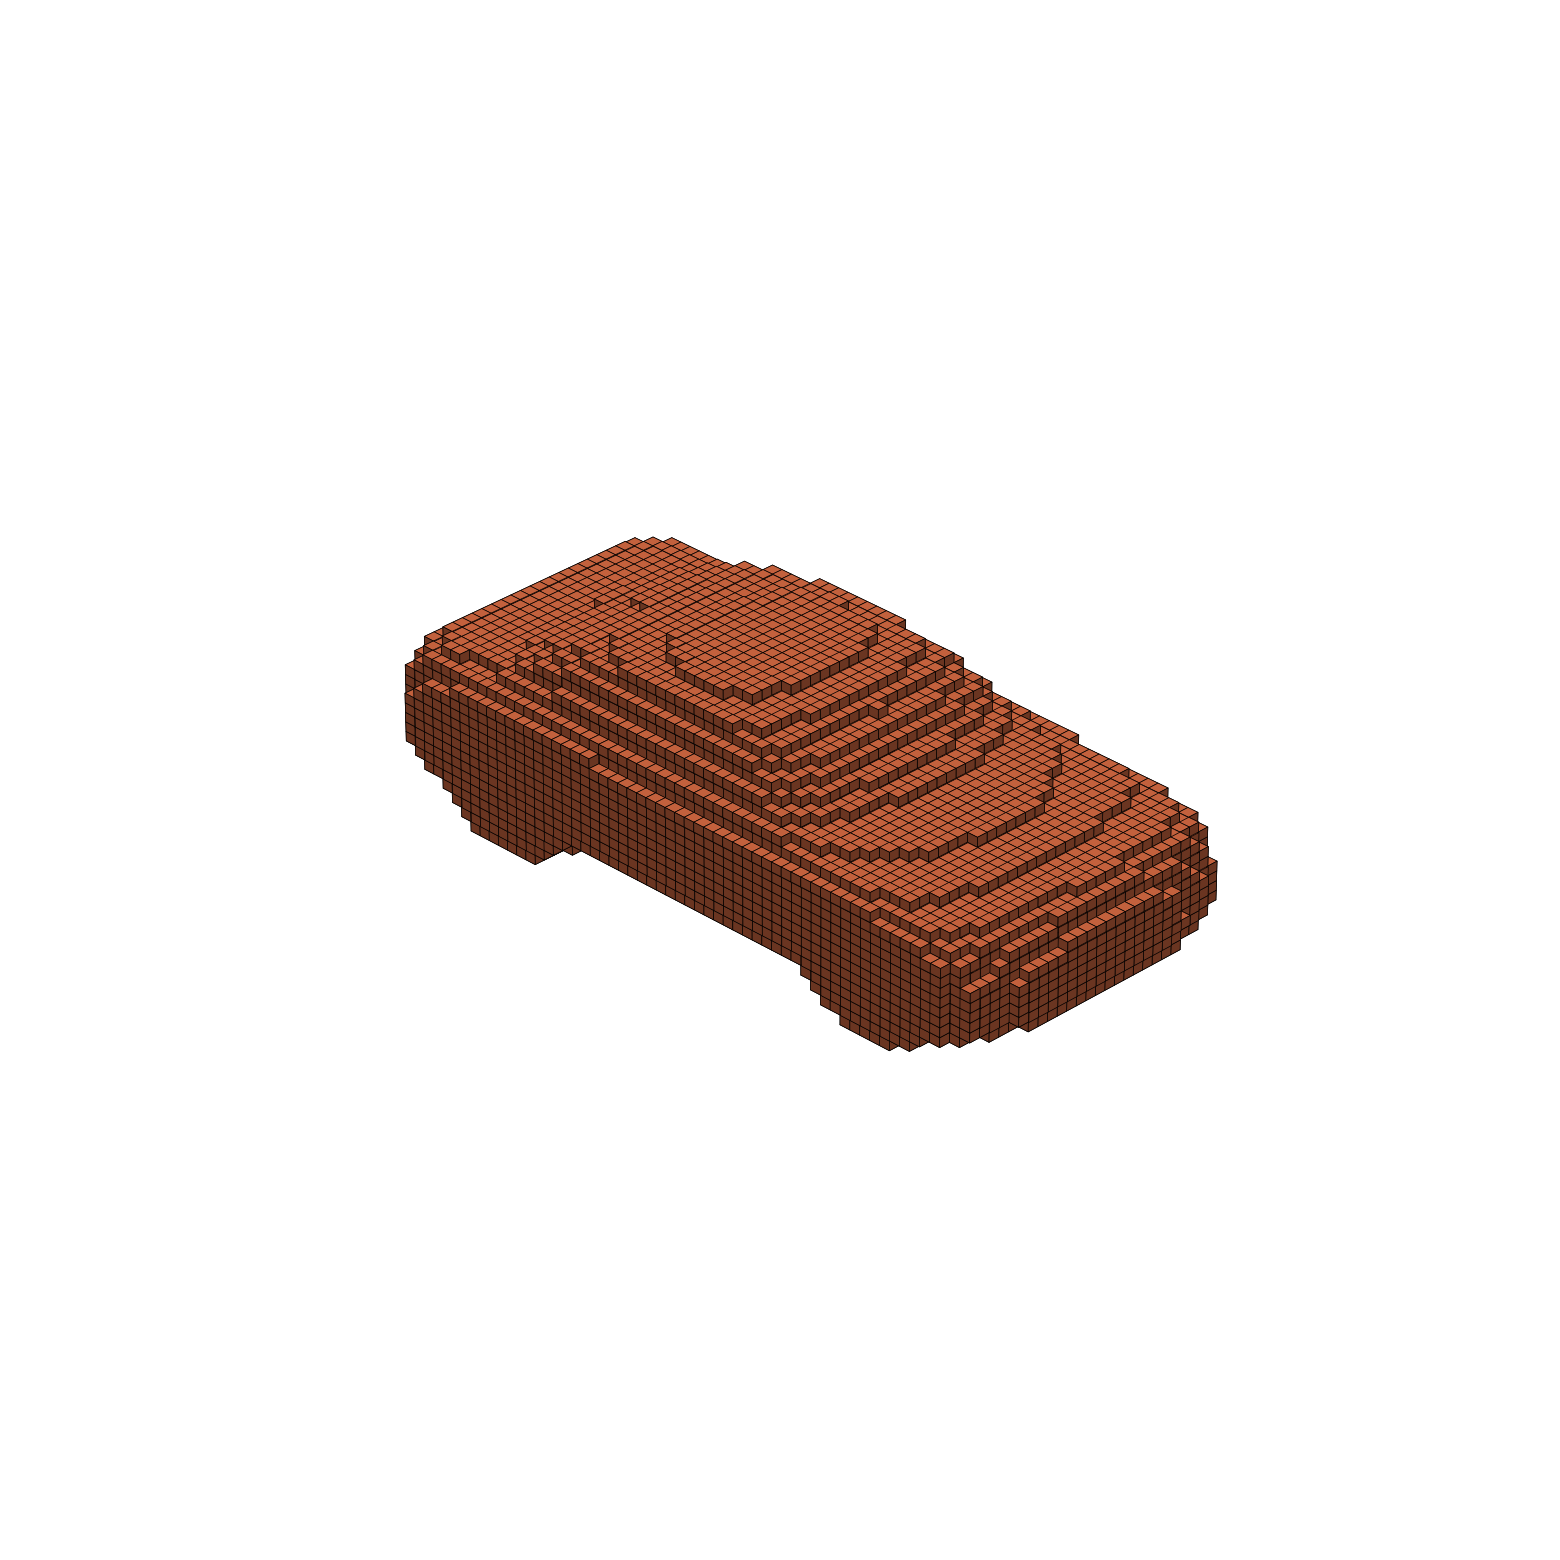

(1, 64, 64, 64)


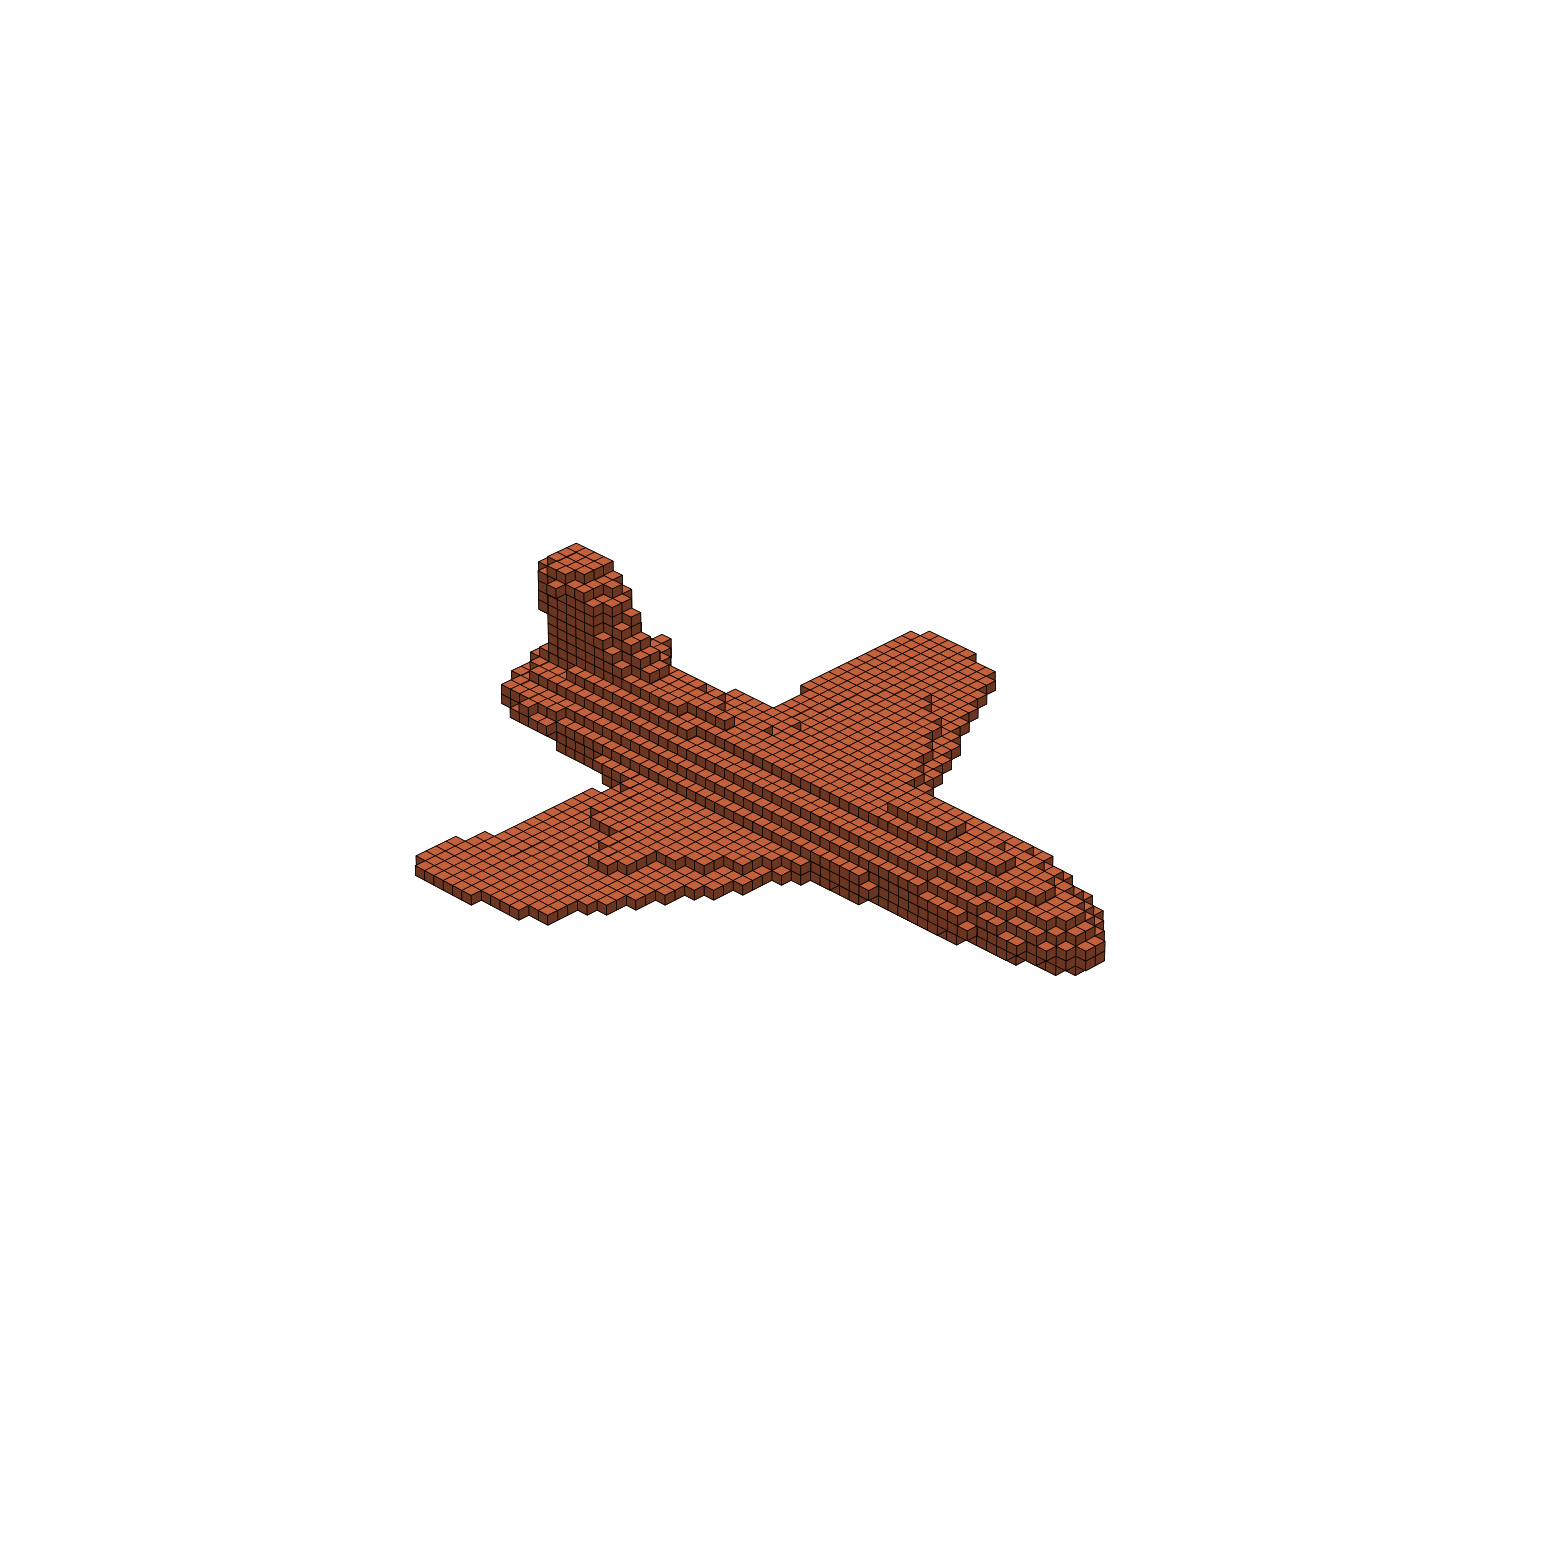

(1, 64, 64, 64)


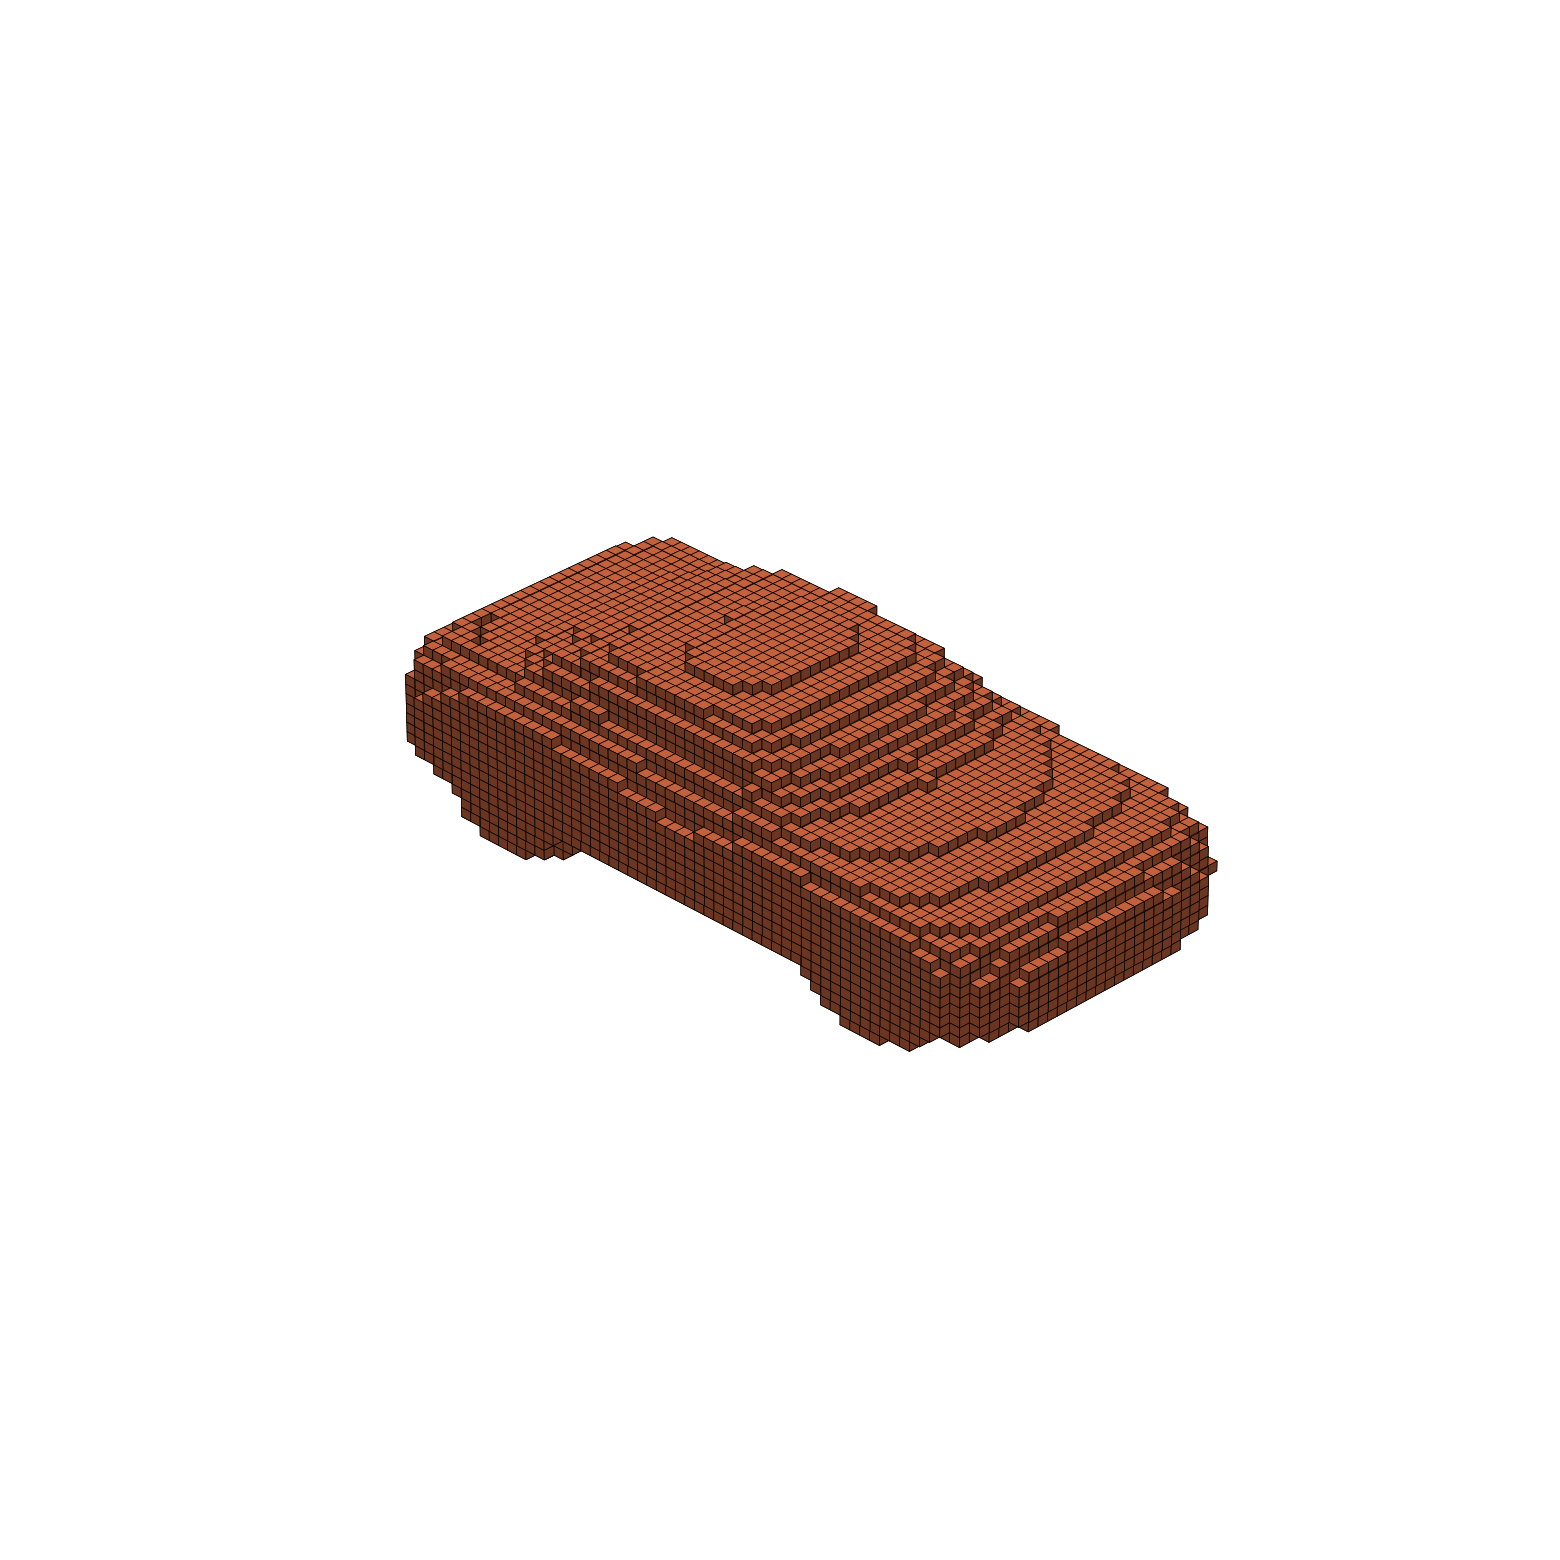

In [15]:
for i in np.array(voxel_output):
    print(i.shape)
    visulization_fn(i[0])

In [16]:
verts, face, _, _ = measure.marching_cubes(voxel_output[0][0] , 0)           
mesh = trimesh.Trimesh(vertices=verts , faces=face , process=False)          
mesh.show()
# mesh.export('chair.glb' , file_type="glb")
# clear_output()

In [17]:
verts, face, _, _ = measure.marching_cubes(voxel_output[1][0] , 0)           
mesh = trimesh.Trimesh(vertices=verts , faces=face , process= False)          
mesh.show()
# mesh.export("plane.glb" , file_type="glb")
# clear_output()

In [18]:
verts, face, _, _ = measure.marching_cubes(voxel_output[2][0] , 0)           
mesh = trimesh.Trimesh(vertices=verts , faces=face)          
mesh.show()
# mesh.export("suv.glb" , file_type="glb")
# clear_output()